# Streamfunction For Zonally Integrated Transport

_Note: this could be done more efficiently, to scale better_

In [1]:
using MeshArrays
include(joinpath(dirname(pathof(MeshArrays)),"gcmfaces_nctiles.jl"))

read_nctiles

Read variables to memory

In [2]:
mygrid=GridSpec("LLC90","../inputs/")
GridVariables=GridLoad(mygrid)
LC=LatitudeCircles(-89.0:89.0,GridVariables)

fileName="../inputs/nctiles_climatology/UVELMASS/UVELMASS"
U=Main.read_nctiles(fileName,"UVELMASS",mygrid)
fileName="../inputs/nctiles_climatology/VVELMASS/VVELMASS"
V=Main.read_nctiles(fileName,"VVELMASS",mygrid)

#U=U[:,:,1]; V=V[:,:,1];
for i in eachindex(U)
    tmp1=U[i]; tmp1[(!isfinite).(tmp1)] .= 0.0
    tmp1=V[i]; tmp1[(!isfinite).(tmp1)] .= 0.0    
    U[i]=GridVariables["DRF"][i[2]]*U[i].*GridVariables["DYG"][i[1]]
    V[i]=GridVariables["DRF"][i[2]]*V[i].*GridVariables["DXG"][i[1]]
end

show(U)

 gcmarray 
  grid type   = llc
  data type   = Float64
  tile array  = (5, 50, 12)
  tile sizes  = (90, 270)
                (90, 270)
                (90, 90)
                (270, 90)
                (270, 90)


Compute overturning streamfunction

In [3]:
s=size(U); nz=s[2]; nl=length(LC)
nt=1; ov=Array{eltype(U),2}(undef,nl,nz)
length(s)>2 ? nt=s[3] : nothing
length(s)>2 ? ov=Array{eltype(U),3}(undef,nl,nz,nt) : nothing
for t=1:nt; for z=1:nz; 
        length(s)>2 ? tmpU=U[:,z,t] : tmpU=U[:,z]
        length(s)>2 ? tmpV=V[:,z,t] : tmpV=V[:,z]
        UV=Dict("U"=>tmpU,"V"=>tmpV,"dimensions"=>["x","y"])
        for l=1:nl
            ov[l,z,t]=ThroughFlow(UV,LC[l],GridVariables)
        end
end; end;

ov=reverse(cumsum(reverse(ov,dims=2),dims=2),dims=2);

Plot annual mean

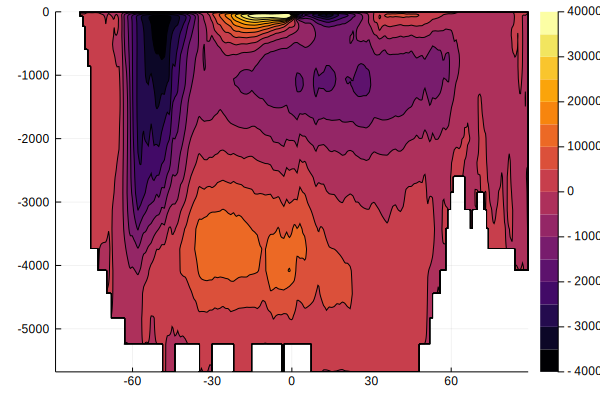

In [4]:
using Plots, Statistics
tmp=dropdims(mean(ov,dims=3),dims=3)
x=vec(-89.0:89.0)
y=reverse(vec(GridVariables["RF"][1:end-1]))
z=reverse(tmp,dims=2)
z[z.==0.0].=NaN
contourf(x,y,transpose(z),clims=(-40e6,40e6))